# Set up farm run

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC
import postproamrwindsample_xarray as ppsamplexr

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
rundir    = 'MMC_NOW23_FarmRun2'
inputfile = 'MMC_NOW23_FarmRun2.inp'

In [4]:
# Go to the run directory
if not os.path.exists(rundir):
    os.makedirs(rundir)
    
cwd = os.getcwd()
os.chdir(rundir)

In [5]:
# Location of precursor run with boundary data
precursordir  = '/nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_Prod/'
precursorsetup= precursordir+'/abl_HPP_MMC.inp'

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [6]:
WDdir = 247.8833

In [7]:
#case.setAMRWindInput('time_control', ['const dt'])
case.setAMRWindInput('time.fixed_dt',  0.02)
case.setAMRWindInput('ABL.stats_output_frequency', 10)

# Set the time constants
case.setAMRWindInput('time.stop_time', 9000.0)

In [8]:
# Set the restart point
chkdir = precursordir+'/chk64000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [9]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
forcingdict = {'ablstatfile':ablstatfile,'tendencyforcing_file':'./tendencyforcing.nc'}
#forcingdict = {'ablstatfile':'','tendencyforcing_file':'./tendencyforcing.nc'}
inflowplanes= ['xlo', 'ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_file/'

In [10]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_BodyForcing=False,
                           autoset_MMCForcing=False,
                           autoset_MMCTendencyForcing=True,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_Prod//bndry_file/'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.103707
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.103707
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET ABLForcing = False
Wrote ./tendencyforcing.nc
SET ABL_tendency_forcing = True
SET ABL_mesoscale_forcing = './tendencyforcing.nc'
SET ABLMesoForcingMom = True
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 64000


## Add Turbines

In [11]:
OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
           "FSTparam_DT_Out:0.02 "
            "ADparam_OutList0:RtAeroFxh "
            "EDparam_YawDOF:False "
            "EDparam_PtfmSgDOF:False "
            "EDparam_PtfmSwDOF:False "
            "EDparam_PtfmHvDOF:False "
            "EDparam_PtfmRDOF:False "
            "EDparam_PtfmPDOF:False "
            "EDparam_PtfmYDOF:False "
            "EDparam_RotSpeed:6.00 "
            "AMRparam_Actuator_epsilon:[2;2;2] "
            "AMRparam_Actuator_epsilon_tower:[2;2;2] "
            "AMRparam_Actuator_openfast_stop_time:2000.0 "
            )

OFoptions += "SDparam_DLL_FileName:/projects/wind_uq/lcheung/AMRWindBuilds/tcf.20240508/ROSCO/ROSCO/build/libdiscon.so "


In [12]:
rotorD   = 240.0
Tspacing = 6
T0x, T0y = -750.0, -500.0
T1x      = T0x + Tspacing*rotorD*np.cos((270.0-WDdir)*np.pi/180.0)
T1y      = T0y + Tspacing*rotorD*np.sin((270.0-WDdir)*np.pi/180.0)

In [13]:
## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,  {T0x},  {T0y}, IEA15MW_ALM, {WDdir}, , {OFoptions}
T1,  {T1x},  {T1y},  IEA15MW_ALM, {WDdir}, , {OFoptions}
""".format(OFoptions=OFoptions, WDdir=WDdir, T0x=T0x, T0y=T0y, T1x=T1x, T1y=T1y)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [14]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

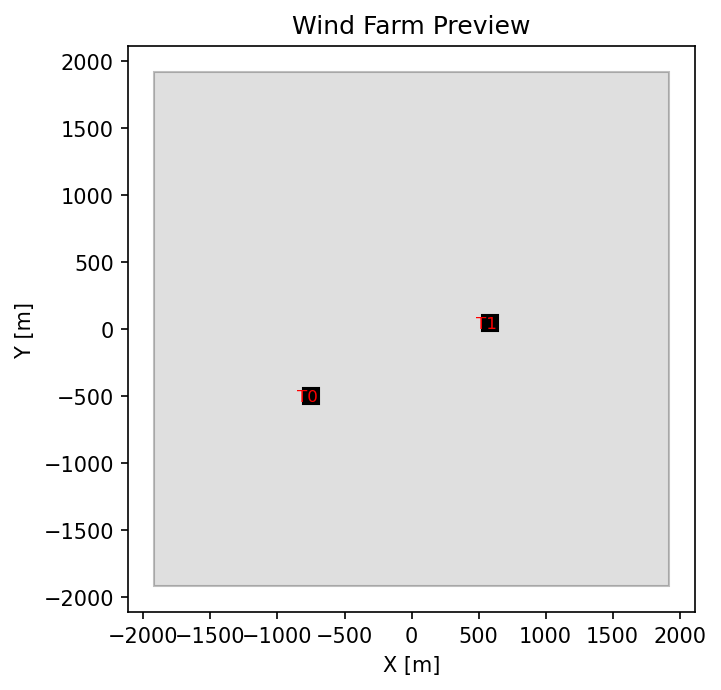

In [15]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [16]:
case.turbines_createAllTurbines()

docopy = True from /projects/wind_uq/lcheung/AdvancedControlsWakes/turbinemodels/OpenFAST3p5_IEA15MW to T0_OpenFAST3p5_IEA15MW
T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_FarmRun2/T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0), ('DT_Out', 0.02)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/projects/wind_uq/lcheung/AMRWindBuilds/tcf.20240508/ROSCO/ROSCO/build/libdiscon.so')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'Fal

22.11670000000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
      0.02 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/projects/wind_uq/lcheung/AMRWindBuilds/tcf.20240508/ROSCO/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translat

docopy = True from /projects/wind_uq/lcheung/AdvancedControlsWakes/turbinemodels/OpenFAST3p5_IEA15MW to T1_OpenFAST3p5_IEA15MW
T1_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /projects/FLOWMASmodel/lcheung/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_FarmRun2/T1_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0), ('DT_Out', 0.02)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/projects/wind_uq/lcheung/AMRWindBuilds/tcf.20240508/ROSCO/ROSCO/build/libdiscon.so')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'Fal

22.11670000000001 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
      0.02 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/projects/wind_uq/lcheung/AMRWindBuilds/tcf.20240508/ROSCO/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translat

## Add refinements

In [17]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,      720,      2300,        600,   150,   480,     center:specified centerx:{T0x} centery:{T0y} units:meter centerz:150 orientation:{WDdir}
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv.format(WDdir=WDdir, T0x=T0x, T0y=T0y))
case.setAMRWindInput('refine_deleteprev', True)

In [18]:
case.refine_createAllZones()
# Print out existing list of refinement zones
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_center_-750_-500_150']


In [19]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0    113246208                5.0 x 5.0 x 5.0
       1    146119679                2.5 x 2.5 x 2.5
  TOTAL:    259365887


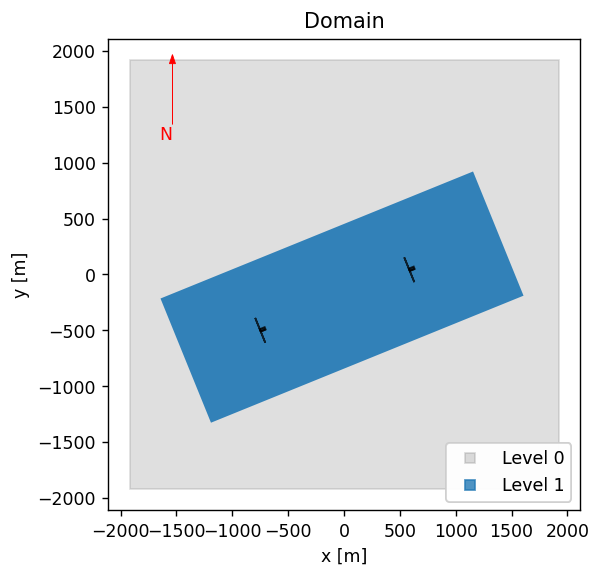

In [20]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = []
case.plotDomain(ax=ax2)

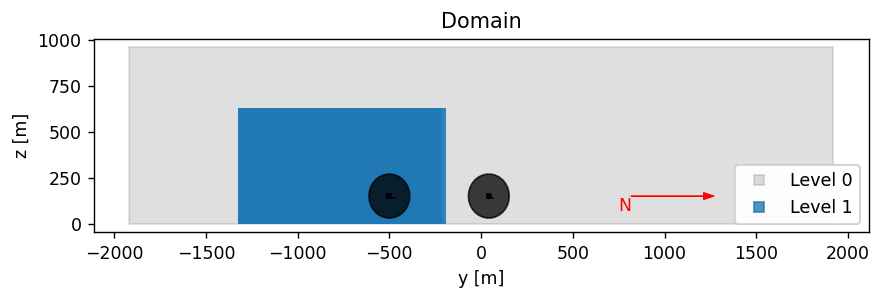

In [21]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## Add sampling planes

In [22]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [23]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:25"

turbsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,                  type,       upstream, downstream, lateral, below, above, n1, n2, options
YZdomain,              rotorplane, 3,        11,         2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZcoarse_   orientation:nacdir outputvars:velocity noffsets:7  {outputoptions} applyto:T0 
XZdomain_coarse,       streamwise, 3,        11,         0,       0.600, 3.0,     11, 11, usedx:0.1   outputto:XZdomaincoarse_ orientation:nacdir  center:farm wholedomain:1 {outputoptions}
XYdomain_coarse,       hubheight,  3,        11,         4,       0,     1.5,     11, 11, usedx:0.1   outputto:XYdomaincoarse_ orientation:nacdir center:farm wholedomain:1  {outputoptions} noffsets:1
XY,                    hubheight,  3,        11,         2,       0.5,   1.5,     11, 11, usedx:0.025  outputto:XY_ orientation:nacdir {outputoptions} noffsets:4 applyto:T0 
XZ,                    streamwise, 3,        11,         0,       0.600, 1.5,     11, 11, usedx:0.025  outputto:XZ_  orientation:nacdir {outputoptions} applyto:T0
XZr,                   streamwise, 3,        11,         2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:XZ_  orientation:nacdir {outputoptions} noffsets:4 applyto:T0 
XZl,                   streamwise, 3,        11,        -2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:XZ_  orientation:nacdir {outputoptions} noffsets:4 applyto:T0 
YZ_inflow1,            rotorplane, 4,        -2,         2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:2  {outputoptions} 
YZ_inflow2,            rotorplane, 1.5,      -1,         2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:1  {outputoptions}
YZ_inflow3,            rotorplane, 0.75,     -0.25,      2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:2  {outputoptions}
YZ_inflow4,            rotorplane, 0.1,      -0.1,       2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:1  {outputoptions}
YZ_wake1,              rotorplane, -0.1,     0.1,        2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:1  {outputoptions}
YZ_wake2,              rotorplane, -0.25,    1.5,        2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:5  {outputoptions}
YZ_wake3,              rotorplane, -2,       4,          2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:4  {outputoptions} applyto:T0
YZ_wake4,              rotorplane, -5,       11,         2,       0.600, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:6  {outputoptions} applyto:T0  
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', turbsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)
#case.sampling_createAllProbes(verbose=True)

In [24]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['T0_YZdomain', 'Farm_XZdomain_coarse', 'Farm_XYdomain_coarse', 'T0_XY', 'T0_XZ', 'T0_XZr', 'T0_XZl', 'T0_YZ_inflow1', 'T1_YZ_inflow1', 'T0_YZ_inflow2', 'T1_YZ_inflow2', 'T0_YZ_inflow3', 'T1_YZ_inflow3', 'T0_YZ_inflow4', 'T1_YZ_inflow4', 'T0_YZ_wake1', 'T1_YZ_wake1', 'T0_YZ_wake2', 'T1_YZ_wake2', 'T0_YZ_wake3', 'T0_YZ_wake4']


(-2000.0, 3000.0)

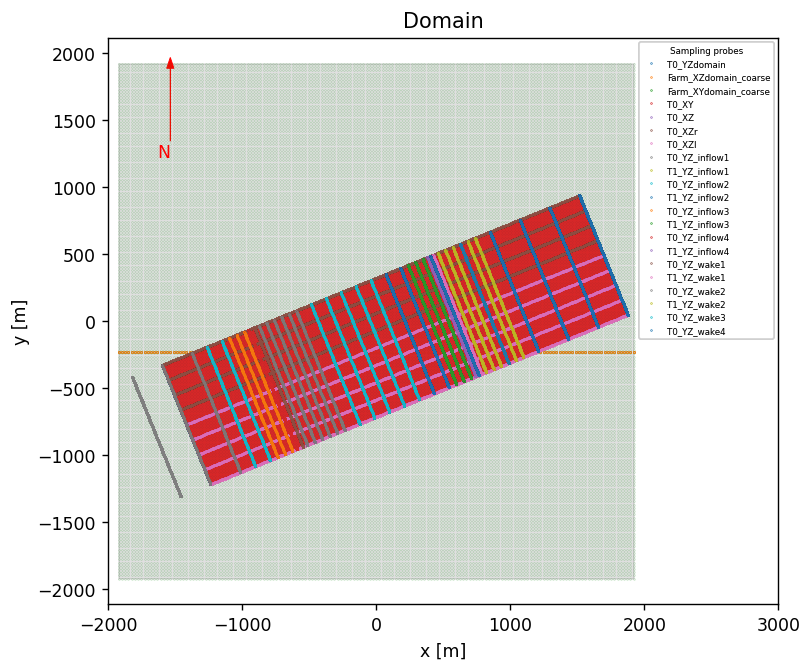

In [25]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None'}"
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':5, 'loc':'upper right', 'markerscale':6}"
case.plotDomain(ax=ax)

ax.set_xlim([-2000, 3000])

In [26]:
case.validate();

-- Checking inputs --
[ PASS] max_level:           max_level = 1 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] restart dir:         Restart directory /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_Prod/chk64000 exists
[ PASS] boundary plane dir:  Restart directory /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_Prod//bndry_file/ exists
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:T0      [T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst] exists
[ PASS] Actuator FST:T0      Actuator density=1.103707, matches incflo.density=1.103707
[ PASS] Actuator FST:T0      CompInflow OK
[ PASS] Actuator FST:T0      [T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_AeroDyn15.dat] exists
[ PASS] Actuator FST:T0      WakeMod=0 OK
[ PASS] Actuator FST:T0      AirDens=1.103707, matche

## Print output

In [27]:
# Write the input file
print(case.writeAMRWindInput(inputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 9000.0              # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.02                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1000                
time.checkpoint_start                    = 64000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_Prod/chk64000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
t